In [2]:
import os
os.chdir('../../..')

In [3]:
import convokit
from convokit import Corpus

In [4]:
os.chdir('convokit/thread_generator')

In [5]:
from convokit.thread_generator import ThreadSpawner

In [23]:
# focused -> expansionary
# t_spawner1 = ThreadSpawner(participant_factor=20, recip_factor=lambda k: 0.9-(0.8)*int(k//11), expansion_factor=lambda k: 1-(0.6)**k)

t_spawner1 = ThreadSpawner(participant_factor=20, recip_factor=lambda k: 0.9-(0.8)*int(k//11), 
                           expansion_factor=lambda k: 0.1+(0.85)*int(k//11))
utts = t_spawner1.spawn_thread(thread_index=1, length=20)
for idx, utt in enumerate(utts):
    utt.meta['order'] = idx + 1
    utt.meta['class'] = 1
Corpus(utterances=utts).get_conversation('1-1').print_conversation_structure(lambda utt: str(utt.meta['order']) + ". " + utt.user.id)

1. 0x1
    2. 0x2
        3. 0x1
            4. 0x2
                5. 0x1
                    6. 0x2
                        7. 0x1
                            19. 0x22
                8. 0x1d
                    9. 0x1
                        10. 0x1d
    11. 0x22
    12. 0x8
    13. 0x1d
    14. 0x25
    15. 0x7
    16. 0x4
    17. 0x27
        18. 0x4
    20. 0xf


In [6]:
# # expansionary -> focused
# t_spawner2 = ThreadSpawner(participant_factor=100, recip_factor=lambda k: 1-(0.9)**k, expansion_factor=lambda k: (0.95)**k)
# utts = t_spawner2.spawn_thread(thread_index=1, length=20)
# for idx, utt in enumerate(utts):
#     utt.meta['order'] = idx + 1
#     utt.meta['class'] = 2
# Corpus(utterances=utts).get_conversation('1-1').print_conversation_structure(lambda utt: str(utt.meta['order']) + ". " + utt.user.id)

In [24]:
# expansionary -> focused
t_spawner2 = ThreadSpawner(participant_factor=20, recip_factor=lambda k: 0.1+(0.8)*int(k//11), 
                           expansion_factor=lambda k: (0.95)-(0.85)*int(k//11))
utts = t_spawner2.spawn_thread(thread_index=1, length=20) # 11 because k is indexed from 3 to 20
for idx, utt in enumerate(utts):
    utt.meta['order'] = idx + 1
    utt.meta['class'] = 2
Corpus(utterances=utts).get_conversation('1-1').print_conversation_structure(lambda utt: str(utt.meta['order']) + ". " + utt.user.id)

1. 0x1
    2. 0x2
    3. 0x1f
    4. 0x15
    5. 0x1a
    6. 0xb
    7. 0x1e
    8. 0x21
    9. 0x23
    10. 0xe
        11. 0x23
            12. 0xe
                13. 0x23
                    14. 0xe
                        15. 0x23
                            16. 0xe
                                17. 0x23
                18. 0x1f
                    19. 0x23
                        20. 0x1f


In [25]:
# dyadic chain
t_spawner3 = ThreadSpawner(participant_factor=4, recip_factor=lambda k: 0.9, expansion_factor=lambda k: 0.2)
utts = t_spawner3.spawn_thread(thread_index=1, length=20)
for idx, utt in enumerate(utts):
    utt.meta['order'] = idx + 1
    utt.meta['class'] = 3
Corpus(utterances=utts).get_conversation('1-1').print_conversation_structure(lambda utt: str(utt.meta['order']) + ". " + utt.user.id)    

1. 0x1
    2. 0x2
        3. 0x1
            4. 0x2
                5. 0x1
                    6. 0x2
                        7. 0x1
                            8. 0x2
                                9. 0x1
                                    10. 0x2
                                        11. 0x1
                                            12. 0x2
                        13. 0x3
                            14. 0x2
                                15. 0x3
                                    16. 0x2
                                        17. 0x3
                                            18. 0x2
                                                19. 0x3
                                                    20. 0x2


## Corpus generation

In [26]:
all_utts = []

In [27]:
group_size = 1500

In [28]:
LENGTH=20
for thread_idx in range(1, group_size+1):
    utts = t_spawner1.spawn_thread(thread_idx, length=LENGTH)
    for utt in utts: utt.meta['subreddit'] = '1.focused->expansionary'
    all_utts.extend(utts)

for thread_idx in range(group_size+1, 2*group_size+1):
    utts = t_spawner2.spawn_thread(thread_idx, length=LENGTH)
    for utt in utts: utt.meta['subreddit'] = '2.expansionary->focused'
    all_utts.extend(utts)
    
for thread_idx in range(2*group_size+1, 3*group_size+1):
    utts = t_spawner3.spawn_thread(thread_idx, length=LENGTH)
    for utt in utts: utt.meta['subreddit'] = '3.dyadic_chain'
    all_utts.extend(utts)


In [29]:
len(all_utts)

90000

In [30]:
corpus = Corpus(utterances=all_utts)

In [31]:
corpus.print_summary_stats()

Number of Speakers: 40
Number of Utterances: 90000
Number of Conversations: 4500


In [32]:
from functools import reduce

In [33]:
for convo in corpus.iter_conversations():
    convo.meta['prob'] = reduce(lambda x, y: x * y, [utt.meta['prob'] for utt in convo.iter_utterances()])

In [35]:
from convokit import HyperConvo

In [36]:
hc20 = HyperConvo(prefix_len=20, feat_name='hyperconvo-20', invalid_val=-1)

In [37]:
hc20.fit_transform(corpus)

## Quantize(?) the probs

In [39]:
from collections import defaultdict
from sklearn.preprocessing import QuantileTransformer
import numpy as np

In [40]:
for convo in corpus.iter_conversations():
    convo.meta['group'] = int(next(convo.iter_utterances()).meta['subreddit'][0])

In [41]:
probs = defaultdict(list)
for convo in corpus.iter_conversations():
    probs[convo.meta['group']].append(convo.meta['prob'])

In [42]:
import seaborn as sns

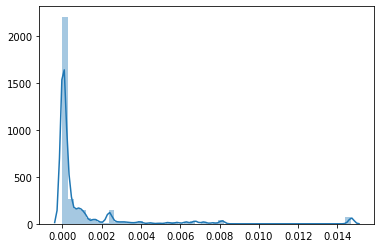

In [43]:
sns.distplot(probs[1])

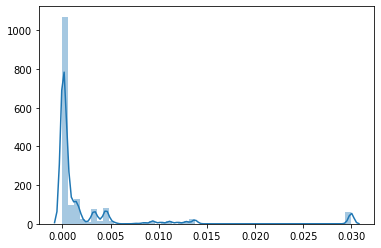

In [44]:
sns.distplot(probs[2])

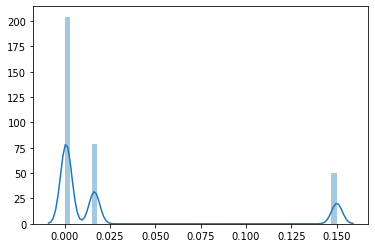

In [45]:
sns.distplot(probs[3])

In [48]:
qt = QuantileTransformer(n_quantiles=18)

In [49]:
percentiles = defaultdict(list)
for k, v in probs.items():
    probs[k] = np.array(v).reshape(-1, 1)
    mm = QuantileTransformer(n_quantiles=18)
    percentiles[k] = mm.fit_transform(probs[k])

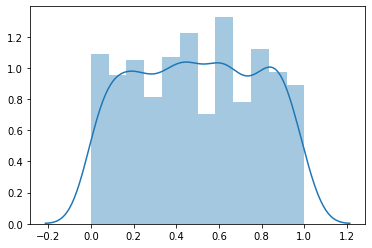

In [50]:
sns.distplot(qt.fit_transform(probs[1]))

In [51]:
for idx, convo in enumerate(corpus.iter_conversations()):
    convo.meta['percentile'] = percentiles[convo.meta['group']][idx % 333][0]

In [52]:
next(corpus.iter_conversations()).meta['percentile']

0.1208424333082472

In [53]:
from convokit import HyperConvo

In [54]:
hyperconv_range = range(2, 20+1)

In [55]:
for hc_idx in hyperconv_range:
    hc = HyperConvo(prefix_len=hc_idx, feat_name="hyperconvo-{}".format(hc_idx), invalid_val=-1)
    hc.fit_transform(corpus)

In [56]:
# corpus = Corpus(filename='annotated-fake-trajectory-2')

In [57]:
# corpus.dump('annotated-fake-trajectory-4', base_path='.')

In [8]:
corpus = Corpus(filename='annotated-fake-trajectory-4')

In [46]:
import pandas as pd
df = corpus.view_conversations()
df_subset = df[['meta.group', 'meta.hyperconvo-20']]
hc_dicts = {df_subset.iloc[idx].name: df_subset.iloc[idx]['meta.hyperconvo-20'] for idx in range(len(df_subset))}
df_hc = pd.DataFrame(hc_dicts).T.astype('float64')
df_combi = pd.concat([df_subset, df_hc], axis=1, sort=False)

In [48]:
df_combi

,meta.group,meta.hyperconvo-20,2nd-argmax[indegree over C->C mid-thread responses],2nd-argmax[indegree over C->C responses],2nd-argmax[indegree over C->c mid-thread responses],2nd-argmax[indegree over C->c responses],2nd-argmax[indegree over c->c mid-thread responses],2nd-argmax[indegree over c->c responses],2nd-argmax[outdegree over C->C mid-thread responses],2nd-argmax[outdegree over C->C responses],...,prop-nonzero[indegree over C->C mid-thread responses],prop-nonzero[indegree over C->C responses],prop-nonzero[indegree over C->c mid-thread responses],prop-nonzero[indegree over C->c responses],prop-nonzero[indegree over c->c mid-thread responses],prop-nonzero[indegree over c->c responses],prop-nonzero[outdegree over C->C mid-thread responses],prop-nonzero[outdegree over C->C responses],prop-nonzero[outdegree over C->c mid-thread responses],prop-nonzero[outdegree over C->c responses]
id,,,,,,,,,,,,,,,,,,,,,
1-1,1,"{'max[indegree over c->c responses]': 10, 'arg...",0.0,1.0,0.0,2.0,0.0,2.0,2.0,10.0,...,0.416667,0.416667,0.421053,0.45,0.421053,0.45,0.333333,1.000000,0.333333,1.000000
2-1,1,"{'max[indegree over c->c responses]': 8, 'argm...",1.0,1.0,0.0,7.0,0.0,7.0,2.0,4.0,...,0.555556,0.555556,0.473684,0.50,0.473684,0.50,0.444444,1.000000,0.444444,1.000000
3-1,1,"{'max[indegree over c->c responses]': 10, 'arg...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.272727,0.272727,0.473684,0.50,0.473684,0.50,0.272727,1.000000,0.272727,1.000000
4-1,1,"{'max[indegree over c->c responses]': 9, 'argm...",0.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,...,0.272727,0.333333,0.421053,0.45,0.421053,0.45,0.363636,0.916667,0.363636,0.916667
5-1,1,"{'max[indegree over c->c responses]': 10, 'arg...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.272727,0.272727,0.473684,0.50,0.473684,0.50,0.181818,1.000000,0.181818,1.000000
6-1,1,"{'max[indegree over c->c responses]': 9, 'argm...",1.0,1.0,1.0,17.0,1.0,17.0,1.0,0.0,...,0.300000,0.300000,0.526316,0.55,0.526316,0.55,0.300000,1.000000,0.300000,1.000000
7-1,1,"{'max[indegree over c->c responses]': 8, 'argm...",0.0,1.0,0.0,8.0,0.0,8.0,1.0,8.0,...,0.444444,0.444444,0.526316,0.55,0.526316,0.55,0.555556,1.000000,0.555556,1.000000
8-1,1,"{'max[indegree over c->c responses]': 8, 'argm...",0.0,2.0,0.0,6.0,0.0,6.0,0.0,1.0,...,0.444444,0.555556,0.526316,0.55,0.526316,0.55,0.444444,1.000000,0.444444,1.000000
9-1,1,"{'max[indegree over c->c responses]': 10, 'arg...",0.0,1.0,1.0,1.0,1.0,1.0,0.0,10.0,...,0.333333,0.333333,0.473684,0.50,0.473684,0.50,0.416667,1.000000,0.416667,1.000000


In [77]:
means = df_combi.groupby('meta.group').mean() #.to_csv('~/Desktop/agg_means.csv')
percent_diff = (means.iloc[0] - means.iloc[1])*2 / (means.iloc[0] + means.iloc[1] + 0.00001)
sum(percent_diff)

-20.058575273713526

In [56]:
pd.set_option("display.max_rows", None)

In [78]:
percent_diff.sort_values()

argmax[outdegree over C->c mid-thread responses]              -1.668452
argmax[indegree over C->C mid-thread responses]               -1.597957
2nd-argmax[outdegree over C->c responses]                     -1.530617
argmax[outdegree over C->c responses]                         -1.526703
argmax[outdegree over C->C mid-thread responses]              -1.445977
2nd-argmax[outdegree over C->c mid-thread responses]          -1.438870
2nd-argmax[outdegree over C->C mid-thread responses]          -1.223761
2nd-argmax[indegree over C->C mid-thread responses]           -1.208408
2nd-argmax[indegree over c->c mid-thread responses]           -1.190487
2nd-argmax[indegree over C->c mid-thread responses]           -1.190487
2nd-argmax[indegree over C->C responses]                      -1.148685
2nd-argmax[indegree over c->c responses]                      -1.095536
2nd-argmax[indegree over C->c responses]                      -1.095536
argmax[outdegree over C->C responses]                         -0

In [57]:
np.sum(np.sum(pd.isnull(percent_diff))) # NaN values

3

In [65]:
from convokit import Utterance, Speaker

In [71]:
not_json_serializable = np.uint64('99')

In [74]:
import json

with open('tester.json', 'w') as f:
    json.dump(not_json_serializable, f)

TypeError: Object of type uint64 is not JSON serializable

In [75]:
cp = Corpus(utterances=[Utterance(id='1', speaker=Speaker(id='hi'), meta={'binary': np.uint64('99')})])

In [76]:
cp.view_utterances()

,timestamp,text,speaker,reply_to,conversation_id,meta.binary
id,,,,,,
1,None,None,hi,None,None,99
